## Data Analysis and Predicting Modeling of Purchase amounts

##### Business Case and DataHack competition hosted by [Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/black-friday/)

###### Autor: [Datageekette](http://datageekette.com/)


#### Problem Statement

A retail company wants to understand the customer purchase behaviour and build a model to predict the purchase amount of customer against various products which will help them to create more personalized offers.

#### Data description

Dataset contains purchase summary of customers for high volume products for a certain period. It also contains customer demographics like age, gender, marital status, city_type, stay_in_current_city, product details and a total purchase_amount.

| VarName | Description |
| --- | --- |
| User_ID| User ID |
| Product_ID | Product ID |
| Gender | Sex of User |
| Age | Age in bins |
| Occupation | Occupation (Masked) |
| City_Category | Category of the City (A, B, C) |
| Stay_In_Current_City_Years | Number of years stay in current city |
| Marital_Status | Marital Status (1 - married, 0 - single) |
| Product_Category_1 | Product Category (Masked) |
| Product_Category_2 | Product may belongs to other category also (Masked) |
| Product_Category_3 | Product may belongs to other category also (Masked) |
| Purchase | Purchase Amount (Target Variable) |           


#### Comments of the author

It's a shame that few variables are masked from the dataset, like Occupation of a customer and Product Categories. Despite that we can still have interesting insights from customer demographics data and answer to the main task: predicting customer purchase amount againt products categories.

This Notebook we created with intention to:
  - create a business case type portfolio project
  - help aspired data analysts to handle their own data analysis workflow
  - got a dipper understanding of algorythms for regression tasks
  
###### Ready or not let's begin.

### I. Overview of Customer demographics

Loading packages and data. Notice that initially I have a splitted data, train and test sets.

In [7]:
# data manipulation
# data visualization + color palette
require(plyr)
require(dplyr)
require(ggplot2)
require(wesanderson)

# loading data
train <- read.csv("~/Documents/projects/blackfriday/train.csv",
                  colClasses = c("integer", "character", rep("factor", 9), "integer"))
test <- read.csv("~/Documents/projects/blackfriday/test.csv",
                  colClasses = c("integer", "character", rep("factor", 9)))

Let's take a quick look:

In [12]:
# glancing at data
glimpse(train)
glimpse(test)

Observations: 550,068
Variables: 12
$ User_ID                    <int> 1000001, 1000001, 1000001, 1000001, 1000...
$ Product_ID                 <chr> "P00069042", "P00248942", "P00087842", "...
$ Gender                     <fctr> F, F, F, F, M, M, M, M, M, M, M, M, M, ...
$ Age                        <fctr> 0-17, 0-17, 0-17, 0-17, 55+, 26-35, 46-...
$ Occupation                 <fctr> 10, 10, 10, 10, 16, 15, 7, 7, 7, 20, 20...
$ City_Category              <fctr> A, A, A, A, C, A, B, B, B, A, A, A, A, ...
$ Stay_In_Current_City_Years <fctr> 2, 2, 2, 2, 4+, 3, 2, 2, 2, 1, 1, 1, 1,...
$ Marital_Status             <fctr> 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...
$ Product_Category_1         <fctr> 3, 1, 12, 12, 8, 1, 1, 1, 1, 8, 5, 8, 8...
$ Product_Category_2         <fctr> , 6, , 14, , 2, 8, 15, 16, , 11, , , 2,...
$ Product_Category_3         <fctr> , 14, , , , , 17, , , , , , , 5, 14, , ...
$ Purchase                   <int> 8370, 15200, 1422, 1057, 7969, 15227, 19...
Observations: 23

Overall dataset contains 790k observations. Notice that I have loaded data with custom data types and most of them are factors due to the nature of data.

Let's now start our data exploration. The best way to do this is to create clear and appealing to eye visualizations.

In [8]:
# unite two splitted sets together for a bigger picture
full <- rbind(train[, 1:11], test)
# assign levels to Marital Status
levels(full$Marital_Status) <- c("s", "m")

In this case it makes sense to create a facet grid graph, which is one of the most used vizs outhere. 
Not suprisingly, as it gives a concise view of distributions by variables in interest.

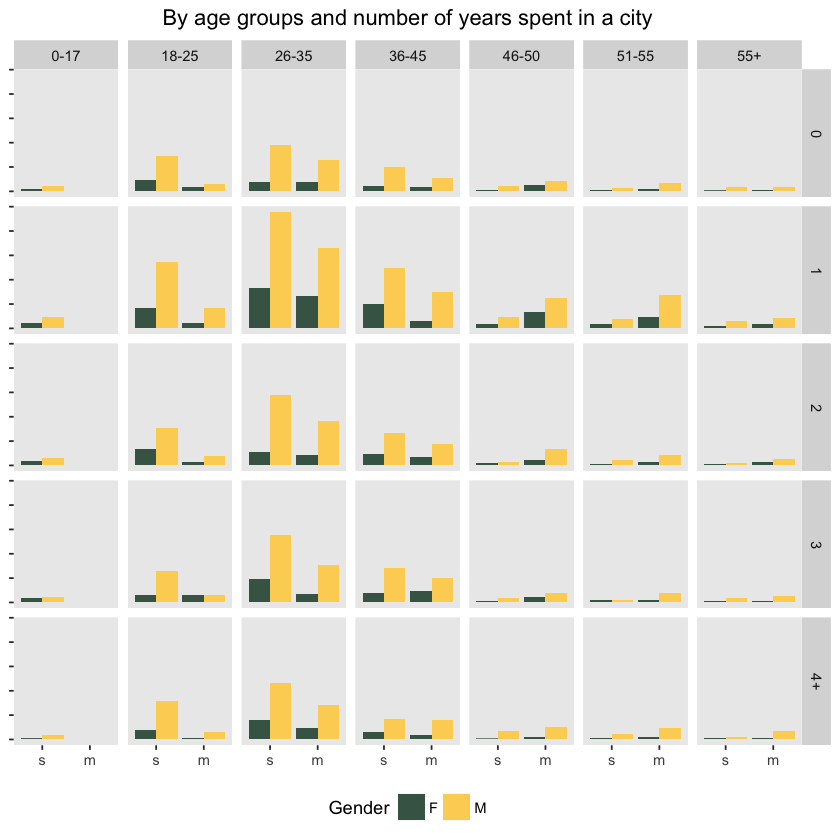

In [9]:
# setting theme
custom_theme <- theme(panel.grid = element_blank(),
          plot.title = element_text(hjust = 0.5))

main <- ggplot(full, aes(x = Marital_Status))
main + geom_bar(aes(fill = Gender),
             position = "dodge") +
    labs(title = "By age groups and number of years spent in a city", 
         x = NULL, y = NULL) +
    facet_grid(Stay_In_Current_City_Years ~ Age) + 
    custom_theme +
    theme(axis.text.y = element_blank(),
          legend.position = "bottom") +
    scale_fill_manual(values = wes_palette(n = 2, name = "Chevalier"))

From the plots above we can now draw a portrait of the most targeted customers by the retailer: it's a man aged between 26 and 35, usually single.

We can also see that an interest in products tends to slow down with age (starting from 26 years old), which leads to a though that there's might be some (human) physical limits involved. 

If the retailor's business sector is sport, then sport's equipment would be at the peak of sales in the exact same age group shown at the graph above (from 26 to 35 years) and under decreasing trend for younger generations (< 25 y) and elderly as these goods are often too expensive for the first one and rarely used by the second.

### II. Data Analysis: Target and Dependent variables

Before building any models we need to make sure that we get familiar with the data.

#### Distribution of target: Purchase amount

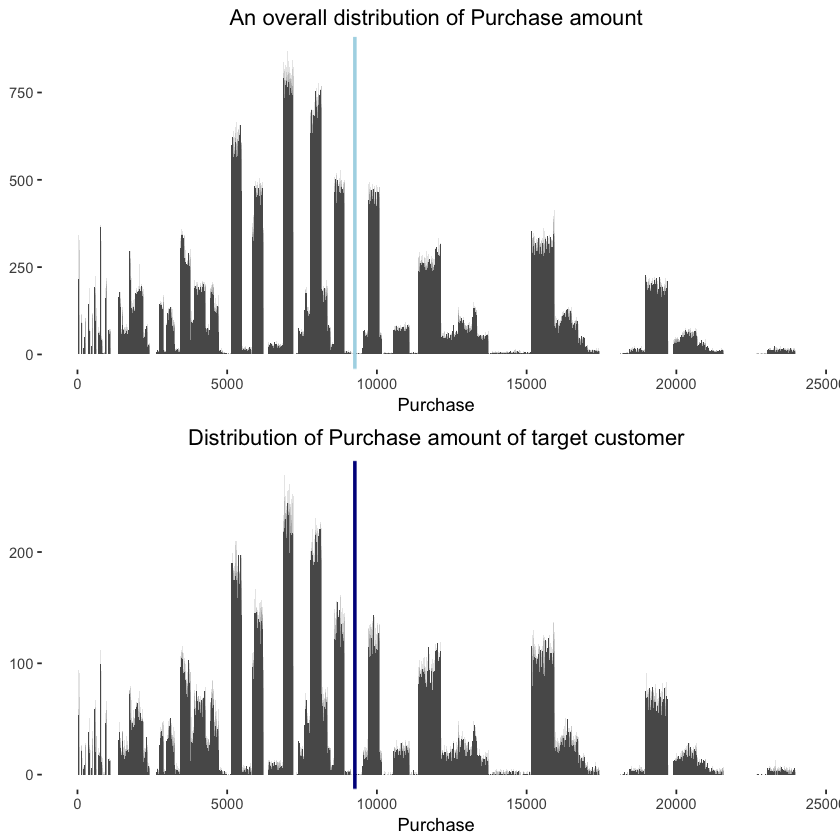

In [10]:
require(gridExtra)

# theme fo histograms
hist_theme <- theme_bw() + 
              theme(panel.grid = element_blank(),
                    panel.border = element_rect(colour = "white"),
                    plot.title = element_text(hjust = 0.5))

h1 <- ggplot(train, aes(x = Purchase)) + 
  geom_histogram(binwidth = 5) +
  labs(title = "An overall distribution of Purchase amount", 
       y = NULL) +
  geom_vline(aes(xintercept = mean(train$Purchase)), 
             col = "lightblue", size = 1) + 
  hist_theme

# customer profile
profile <- train %>%
              filter(Gender == 'M' & Age == '26-35')

h2 <- ggplot(profile, aes(x = Purchase)) + 
  geom_histogram(binwidth = 5) +
  labs(title = "Distribution of Purchase amount of target customer", 
       y = NULL) +
  geom_vline(aes(xintercept = mean(train$Purchase)), 
             col = "darkblue", size = 1) +
  hist_theme

grid.arrange(h1, h2)

From the plot above we can see that even though the distribution is skewed to the right, which impacted the average amount of Purchase, and there are some groupings among highest amount, the distribution is still concise with the most popular customer profile.

If we were digging deeper in demographics we would see that the distribution doesn't change much with it. The only set of variables that do impact the purchase amount is a set of products categories.

As for outliers, we can easily spot them on graphs above. They correspond to sales with purchase amounts above 22k. Most of the time decision for including or excluding outliers depends on the origine of data. Here we have already cleaned data, so these high amounts represent real data points. 

#### Product Categories

Let's take a look at the product categories. I remind that every next column describes to which category a product belongs in addition to the first (main) category. 

In [11]:
train %>% 
  select(9:11) %>%
  summary()

 Product_Category_1 Product_Category_2 Product_Category_3
 5      :150933            :173638            :383247    
 1      :140378     8      : 64088     16     : 32636    
 8      :113925     14     : 55108     15     : 28013    
 11     : 24287     2      : 49217     14     : 18428    
 2      : 23864     16     : 43255     17     : 16702    
 6      : 20466     15     : 37855     5      : 16658    
 (Other): 76215     (Other):126907     (Other): 54384    

Eventhough there is an issue with NA's here we will leave them as there are. 

Most of the products belong to first-type categories: 1, 5, 8.  Let's see how purchase amount are distributed by these categories:

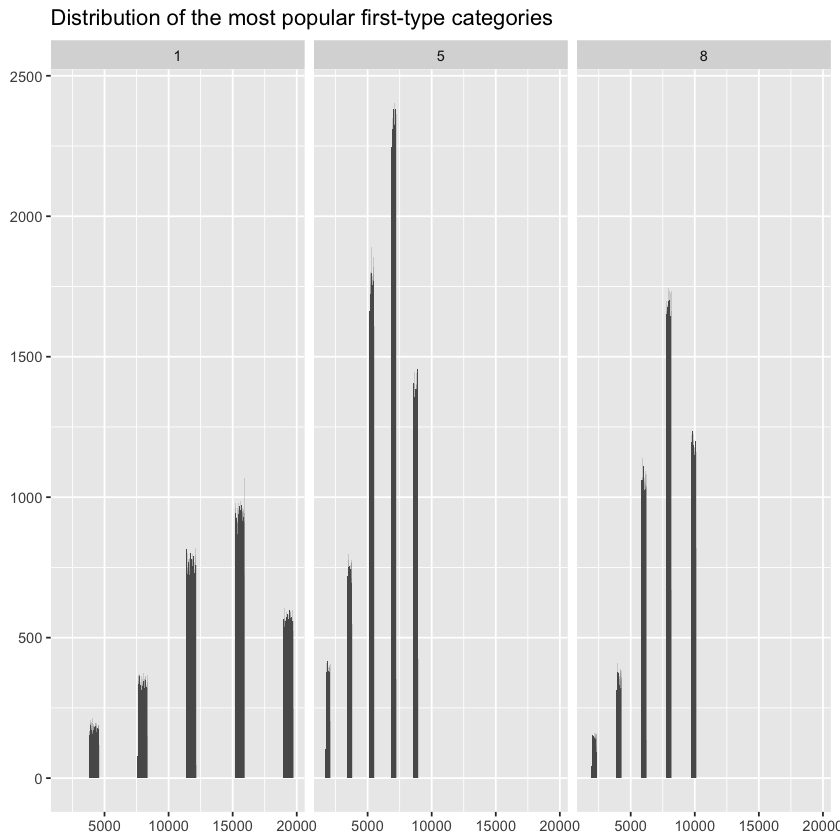

In [12]:
ggplot(train[,9:12] %>%
         filter(Product_Category_1 == 1 | Product_Category_1 == 8 | Product_Category_1 == 5), 
       aes(x = Purchase)) + 
  geom_histogram(binwidth = 15) +
  labs(title = "Distribution of the most popular first-type categories", 
       x = NULL, y = NULL) +
  facet_grid(~ Product_Category_1)

As we see the distribution of purchase amounts change by product categories. Which leads us to the thought that indeed product categories are relevant predictors for this case.

### III. Predictive modeling of Purchase amount

#### From baseline to advanced

It's in practice to start off the process by building the baseline model. In our example, for regression task where the ourcome is a continious variable, it's in practice to use an average of a target. Here it's an average amount of the customer purchase.

In order to evaluate the performance of the algorythm we will not only look at the error metric but also at its speed. 

For continuous outcome, the main error metric to evaluate is the RMSE (root mean squared error). Thise measure gives more weight to larger residuals (the difference between the predicted and the observed value) than to smaller ones. 
This essentially means that we consider that missing the prediction for the 2x higher amount of Purchase is not only twice as bad as missing x1 amount, but even worse than that. Essentially we want this number to drop to its lowest.

We also focus on overfitting: it's a regression task that predicts a continious amount and not a binary outcome. So it's even more important that a final model could generalize well to unseen data.

Dislcamer: this notebook is done entirely in R. There are great Python sklearn alternatives for XGBoost and Random Forest which are also faster. I will try to cover those in next notebooks.

In [13]:
# Baseline model 'predicts' the mean of the training data
base <- mean(train$Purchase) 

# Evaluate RMSE and print it out 
cat('RMSE of ', sqrt(mean((train$Purchase - base)^2)), 
    " will be considered as a baseline for further compairison.") 

RMSE of  5023.061  will be considered as a baseline for further compairison.

We begin with a random forest, which is widely used algorythm not only for classification but also for regression tasks. Like this one. 

Random Forest usually outperforms basic Decision tree algrotyhm. Which is logical as it creates a set of trees instead of single one. It 'grows a forest'.

Linear regression, as the basic model to start with, would be also a bad choice here. For one reason at least - it makes 'linear' assumptions about the relation between outcome and predictors.

to follow ...